In [1]:
import pandas as pd
import numpy as np
import urllib
from PIL import Image
from bs4 import BeautifulSoup
import requests
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
movies_df = pd.read_csv("shuffled_movie_df.csv")

# File Summary 
This File contains our study of how color may be related to genre. What we did was looped through all the 100 posters in each genre and created a dataframe of all the pixels from the 100 posters. Then we ran KMeans on each collection of pixels per genre to generate the top 16 colors that occured in each grouping of pixels. Then we used the seaborn library to create color palettes and sorted the colors based on their "b" value to see if there was a correlation between the genres. 

In [3]:
import time
from sklearn.cluster import KMeans
import imageio
import numpy as np
import operator
genre_colors_df = pd.DataFrame()
def get_weights(clt):
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    weights = hist.astype("float")
    weights /= weights.sum()
    top_colors= clt.cluster_centers_
    weighted_colors = []
    for (weight, color) in zip(weights, top_colors):
        weighted_colors.append((color,weight))
    weighted_colors.sort(key=operator.itemgetter(1),reverse=True)
    return weighted_colors
genres=["Horror","Western","War","Sci-Fi","Action","Adventure",
       "Crime","Romance","Comedy","Thriller","Drama"]
colors={}
for genre in genres:
    print(genre)
    genre_df = movies_df[movies_df["Genre"] == genre]
    first_iteration = True
    for image_link in genre_df["Poster Image Link"]:
        urllib.request.urlretrieve(image_link,"poster2.jpg")
        img = imageio.imread('poster2.jpg') # 640x480x3 array
        temp_pixel_arr = np.asarray(img)
        if(first_iteration):
            pixel_arr = temp_pixel_arr.reshape((temp_pixel_arr.shape[0] * temp_pixel_arr.shape[1], 3))
            first_iteration=False
        else:
            pixel_arr += temp_pixel_arr.reshape((temp_pixel_arr.shape[0] * temp_pixel_arr.shape[1], 3))
    colors[genre] = pixel_arr        
genre_colors_df = pd.DataFrame([colors])
genre_colors_df

Horror
Western
War
Sci-Fi
Action
Adventure
Crime
Romance
Comedy
Thriller
Drama


,Action,Adventure,Comedy,Crime,Drama,Horror,Romance,Sci-Fi,Thriller,War,Western
0,"[[15, 57, 105], [132, 139, 130], [23, 219, 158...","[[14, 1, 248], [48, 204, 197], [142, 200, 156]...","[[179, 5, 159], [186, 34, 23], [246, 52, 136],...","[[131, 108, 96], [125, 37, 33], [78, 222, 164]...","[[212, 113, 26], [142, 251, 161], [220, 22, 16...","[[225, 246, 91], [238, 197, 244], [134, 248, 7...","[[30, 45, 60], [52, 72, 130], [43, 244, 124], ...","[[115, 120, 61], [78, 245, 178], [133, 223, 91...","[[60, 223, 7], [167, 247, 234], [249, 12, 225]...","[[208, 66, 108], [110, 205, 17], [28, 146, 240...","[[11, 55, 161], [56, 163, 45], [79, 252, 47], ..."


In [9]:
genre_colors_df.to_csv("poster_colors_by_genre.csv",index=False)

### Clustering to receive the top 16 colors in each grouping of pixels
We run K-Means clustering with 16 clusters on all movie posters grouped by the movie genre (not individual posters -- we get all the pixels of all the posters for each genre and run K-means on these grouped pixels). This way, we get the top colors in movie posters for each genre and observe if there is an apparent trend between movie poster colors and movie gennre.  

In [16]:
colors_16df = pd.DataFrame()
for genre in genre_colors_df.columns:
    pixel_arr = genre_colors_df[genre].loc[0]
    model = KMeans(n_clusters = 16)
    model.fit(pixel_arr)
    weights = get_weights(model)
    colors={}
    rows=[]
    for i in range(0,16):
        color = weights[i][0]
        r_key = "r" + str(i+1)
        g_key = "g" + str(i+1)
        b_key = "b" + str(i+1)
        colors[r_key] = color[0]
        colors[g_key] = color[1]
        colors[b_key] = color[2]
    rows.append(colors)
    temp_df = pd.DataFrame(rows)
    colors_16df = pd.concat([colors_16df,temp_df],ignore_index=True)
colors_16df.head()

,b1,b10,b11,b12,b13,b14,b15,b16,b2,b3,...,r15,r16,r2,r3,r4,r5,r6,r7,r8,r9
0,205.066605,132.566402,208.604691,122.833624,179.787471,128.038182,36.316302,58.378395,50.143602,61.062379,...,40.724453,128.148148,208.117536,217.381528,55.423291,215.665952,43.930661,57.860802,42.118465,133.731694
1,51.996232,116.417097,39.682576,185.894158,209.873337,108.216343,179.530496,215.857654,47.951819,46.823247,...,216.599111,130.614449,53.833255,51.724304,202.840040,128.479145,198.985386,72.887234,51.862777,125.881490
2,65.151586,41.964227,173.356474,130.750431,125.958549,121.650645,128.875862,49.825428,203.128936,211.805215,...,47.045768,37.970356,66.839080,208.656953,206.221814,205.928947,205.528699,131.990307,67.430038,134.581958
3,47.511660,38.739006,113.260495,111.434933,187.149851,211.372294,182.670405,216.262865,46.822816,50.802927,...,219.014953,131.317107,52.706796,202.427805,52.700537,199.050131,126.896138,129.960254,49.606514,73.614664
4,43.674920,202.116056,121.744729,43.885350,165.172781,117.564596,214.268176,215.560628,196.143462,46.117733,...,116.768176,42.796719,215.890875,206.001954,209.422829,205.018330,52.078692,135.746943,45.780449,60.126667


In [18]:
colors_16df.index = ["Horror","Western","War","Sci-Fi","Action","Adventure",
       "Crime","Romance","Comedy","Thriller","Drama"]

In [20]:
index_list = []
for i in range(0,16):
    index_list.append("r"+str(i+1))
    index_list.append("g"+str(i+1))
    index_list.append("b"+str(i+1))
colors_16df = colors_16df.reindex(index_list, axis="columns")

In [22]:
colors_16df.to_csv("colors16_genre.csv",index=False)
colors_16df

,r1,g1,b1,r2,g2,b2,r3,g3,b3,r4,...,b13,r14,g14,b14,r15,g15,b15,r16,g16,b16
Horror,202.460685,47.588344,205.066605,208.117536,51.616588,50.143602,217.381528,195.651838,61.062379,55.423291,...,179.787471,131.633333,41.249697,128.038182,40.724453,177.046229,36.316302,128.148148,213.811111,58.378395
Western,204.346208,207.867169,51.996232,53.833255,206.874823,47.951819,51.724304,50.334774,46.823247,202.840040,...,209.873337,210.159318,129.383304,108.216343,216.599111,41.365947,179.530496,130.614449,46.120172,215.857654
War,61.237873,36.430970,65.151586,66.839080,37.733133,203.128936,208.656953,198.351227,211.805215,206.221814,...,125.958549,217.451934,126.512896,121.650645,47.045768,202.993103,128.875862,37.970356,122.826087,49.825428
Sci-Fi,201.806903,51.822761,47.511660,52.706796,50.475243,46.822816,202.427805,210.610244,50.802927,52.700537,...,187.149851,197.356215,128.218924,211.372294,219.014953,41.717134,182.670405,131.317107,45.665508,216.262865
Action,52.391105,198.047685,43.674920,215.890875,199.389934,196.143462,206.001954,202.994138,46.117733,209.422829,...,165.172781,211.059006,122.951553,117.564596,116.768176,210.919067,214.268176,42.796719,132.106990,215.560628
Adventure,50.373934,206.891469,202.835071,49.920174,204.702951,47.254959,202.250000,57.896943,40.850099,193.435948,...,211.884728,38.445639,74.526284,213.948029,61.309466,39.604369,127.436286,126.896431,38.016795,207.351295
Crime,218.214019,69.742056,191.160748,56.090597,38.071009,57.806562,41.593500,54.719000,199.582000,47.280836,...,211.423366,183.974912,214.563594,43.139440,39.301998,129.646886,125.201528,139.501506,37.487952,209.350151
Romance,50.283380,49.298786,52.060691,50.740793,47.265817,204.082625,46.991133,205.915271,205.202463,46.713206,...,129.535692,183.847706,215.438532,215.603058,211.074122,125.419376,200.973992,214.723886,206.485030,131.111776
Comedy,203.057450,205.113498,49.121439,47.875062,206.250864,52.903704,43.522716,56.318530,48.469117,57.564392,...,216.732123,133.760805,51.674956,204.335110,122.224478,139.414328,39.389254,59.827937,125.923810,215.020952
Thriller,51.513770,206.562678,205.202754,45.591176,49.334314,55.422549,49.813052,50.878312,206.741904,46.637395,...,177.610918,121.944840,133.793594,212.673784,179.565632,40.952267,37.760740,214.906334,50.078841,123.382749


### Generating the palette formed for all 16 colors for each of the genres
The colors in each Genre are ordered by their weights. This means, the first color is the most prominent colors in the posters in that genre and the last color is the least prominent color in the posters in that genre.

Horror Color Palette:


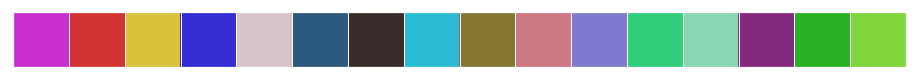

Western Color Palette:


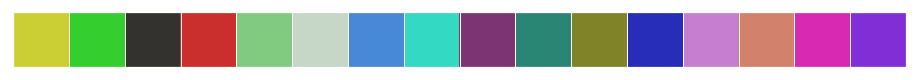

War Color Palette:


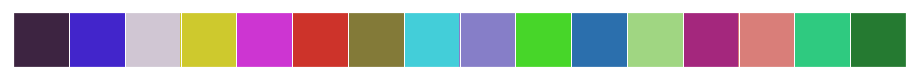

Sci-Fi Color Palette:


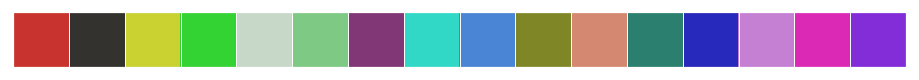

Action Color Palette:


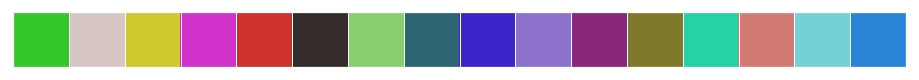

Adventure Color Palette:


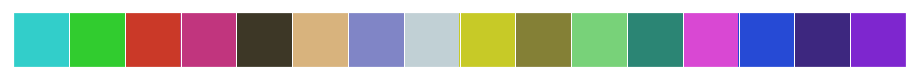

Crime Color Palette:


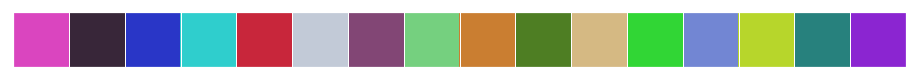

Romance Color Palette:


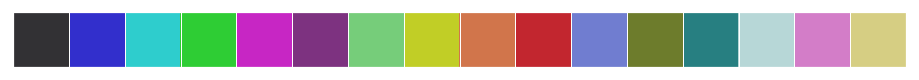

Comedy Color Palette:


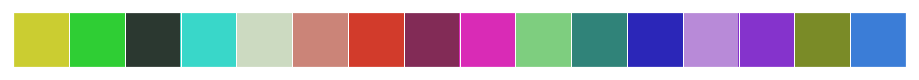

Thriller Color Palette:


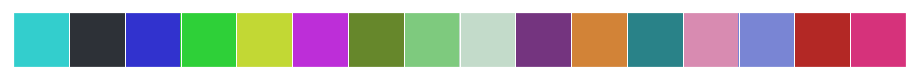

Drama Color Palette:


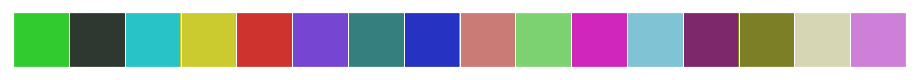

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set()
from operator import itemgetter
genres=["Horror","Western","War","Sci-Fi","Action","Adventure",
       "Crime","Romance","Comedy","Thriller","Drama"]
for genre in genres:
    colors = colors_16df.loc[genre]

    rgb_palette = []
    color = []
    i = 0
    for c in colors:
        color.append(c/255.0)
        if((i+1)%3 == 0):
            rgb_palette.append(color)
            color = []
        i+=1
    start = "\033[1m"
    end = "\033[0;0m"
    print(start + genre+" Color Palette:" + end)

    sns.palplot(sns.color_palette(rgb_palette))
    plt.show()

# Results
According to the palettes above we can see that the top 16 colors when sorted by the weights (how prominent the color is in each genre), are approximately the same across all of the genres. This means that there is, apparently, only a weak correlation between the poster colors and the genre. But, number are more promising than just looking at colors. So, in ML_2, we still build a model using poster colors as features to predict movie genre and we analyse it. The goal is to potentially include this model in the ensembler model with other models using Synopsis text and Key Words text as features if it yields the best results.